# ML: Breast Cancer

## Strategy

- Data split:
    - Data is split into **train (90%)** and **test (10%)**
    - Train data is used for cross-validation as well when performing hyperparameter tuning 
- Encoding:
    - y data: **LabelEncoder**
    - x data: 
        - manual encoding to genetic mutations features: 0: no mutation occured, 1: mutation occured
        - using **label encoder** to the rest of categorical features
- Null/empty values:
    - Used **KNNImputer**:
        - predicted the value of a missing data point by averaging the values of its k nearest neighbors based on Euclidean distance metric.
        - number of neighbors is set to 2 
- Addressing **Data imbalance**:
    - Generated synthetic examples in the minority class using **SMOTE** oversampling algorithm
- Feature selection:
    - Used **RandomForestClassifier** to select the needed features 
    - Removed features from x_train data
- Model training:
    - Used **XGBClassifier** as it was stated in multiple papers for yielding the best results 
    - Used **f1_macro** for scoring 
    - Fit using **train** data
- Testing:
    - Pre-processing applied:
        - Handle null/empty values similar to the handling of the train data
        - Encode the test data 
        - Remove the features removed from **x_train** from **x_test** 
    - Generate predictions
    - Display the following metrics:
        - Accuracy 
        - Precision 
        - Recall 
        - F1 Score 

## Part 0: Pre-requisites 

### Imports

In [7]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.feature_selection import RFE
import sklearn
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

### Functions:

In [2]:
'''
    function to plot learning curve
'''
def plot_learning_curves(model, x_train, y_train):
    train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
#################################################################################################
'''
    functions to save model and retrieve model
'''
path = "Models\\"
def saveModel(fileName, model):
  with open(path + fileName, 'wb') as f:
      pickle.dump(model, f)

def getModel(fileName):
  with open(path + fileName, 'rb') as f:
      loaded_model = pickle.load(f)
  return loaded_model

results = [] # Array used to store tuples of (model, accuracy_score)
#################################################################################################
'''
    function to split data
'''
def train_val_test_split(x, y):
    # Splitting into training (80%) and temporary set (20%)
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=3)
    # Splitting the temporary set into validation (50%) and test (50%)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True, random_state=3)
    return x_train, y_train, x_val, y_val, x_test, y_test
#################################################################################################
'''
    function to find the distribution of null values in the dataset
'''
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
    "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

## Part 1: Data 

### Load the data 

In [ ]:
data = pd.read_csv("data.csv", encoding="utf-8")
data.head()

In [8]:
print(data.shape)
print(data[data['cancer_type'] == "Breast Invasive Ductal Carcinoma"].shape[0])
print(data[data['cancer_type'] == "Breast Invasive Lobular Carcinoma"].shape[0])
print(data[data['cancer_type'] == "Breast Mixed Ductal and Lobular Carcinoma"].shape[0])
print(data[data['cancer_type'] == "Breast Invasive Mixed Mucinous Carcinoma"].shape[0])

(1496, 688)
1199
114
165
18


↪ Our dataset is imbalanced
- we cannot undersample due to the fact that our dataset is mall
- random oversampling may lead to overfitting
- there are other techniques for oversamplign (**SMOTE**)
- setting class weights in an inversely prop way to its freq.
- **boosting** and **bagging** models, **random forest** model are good options.
- use **f1-score** or any metric that is sensitive to data imbalance.  

##### Split into features (x) and label (y)

In [4]:
# splitting data and dropping unnecessary features
y = data["cancer_type"]
x = data.drop(columns = ["cancer_type","patient_id"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True, random_state=3)

In [5]:
def data_encoding(x, y):
    ordinal_features = ['cellularity','3-gene_classifier_subtype','death_from_cancer','pam50_+_claudin-low_subtype','her2_status_measured_by_snp6']# should add the genetic mutation cols too
    nominal_features = ['er_status_measured_by_ihc','er_status','her2_status','inferred_menopausal_state','primary_tumor_laterality','pr_status']

    x[ordinal_features] = x[ordinal_features].apply(LabelEncoder().fit_transform)
    x[nominal_features] = x[nominal_features].apply(LabelEncoder().fit_transform)

    genomic_col = x.columns[513:] # genetic mutations
    for col in genomic_col:
        x.loc[x[col] != '0', col] = 1
        x.loc[x[col] == '0', col] = 0
        x[col] = x[col].astype(int)
    
    # encoding labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return x,y

def data_encoding2(x,y):
    def get_categorical_columns(df):
        return list(df.select_dtypes(include=['object', 'category']).columns)
    def get_numerical_columns(df):
        return list(df.select_dtypes(include=['number']).columns)

    categorical_columns = get_categorical_columns(x)
    numerical_columns = get_numerical_columns(x)

    # Clean categorical columns to remove duplicates and unexpected formats
    def clean_categorical_columns(df, cat_columns):
        cleaned_df = df.copy()
        for col in cat_columns:
            cleaned_df[col] = cleaned_df[col].apply(lambda x: str(x).strip())  # Strip leading/trailing spaces
            cleaned_df[col] = cleaned_df[col].apply(lambda x: ' '.join(sorted(set(x.split()))))  # Remove duplicate words
        return cleaned_df

    def clean_target_variable(y):
        cleaned_y = y.copy()
        cleaned_y = cleaned_y.apply(lambda x: str(x).strip())  # Strip leading/trailing spaces
        cleaned_y = cleaned_y.apply(lambda x: ' '.join(sorted(set(x.split()))))  # Remove duplicate words
        return cleaned_y

    x_cleaned = clean_categorical_columns(x, categorical_columns)
    y_cleaned = clean_target_variable(y)

    # Use LabelEncoder for encoding target variable
    label_encoder_y = LabelEncoder()
    y_encoded = label_encoder_y.fit_transform(y_cleaned)

    encoder = ce.TargetEncoder(cols=categorical_columns)
    x_encoded = encoder.fit_transform(x_cleaned, y_encoded)

    return x_encoded, y_encoded

def impute_missing_values_KNN(x):
    imputer = KNNImputer(n_neighbors=2)
    x.iloc[:,:] = imputer.fit_transform(x)
    return x

def feature_selection(x, y):
    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(estimator=rf_classifier, n_features_to_select=None)

    # Fit the classifier to the data
    rfe.fit(x, y)

    selected_features_indices = np.where(rfe.support_)[0]
    return selected_features_indices

def data_upsampling(x, y):
    # summarize distribution before upsampling
    counter = Counter(y)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    plt.bar(counter.keys(), counter.values(    ))
    plt.show()

    oversample = SMOTE()
    x, y = oversample.fit_resample(x, y)
    # summarize distribution after upsampling
    counter = Counter(y)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    plt.bar(counter.keys(), counter.values())
    plt.show()
    return x,y

def preprocess_data(x,y):
    x,y = data_encoding(x, y)
    x = impute_missing_values_KNN(x)
    x,y = data_upsampling(x, y)
    selected_features_indices = feature_selection(x, y)
    x = x.iloc[:, selected_features_indices]
    return x,y,selected_features_indices


## Part 3: Models

### XGBOOST:

Class=0, n=1081 (80.312%)
Class=1, n=100 (7.429%)
Class=3, n=149 (11.070%)
Class=2, n=16 (1.189%)


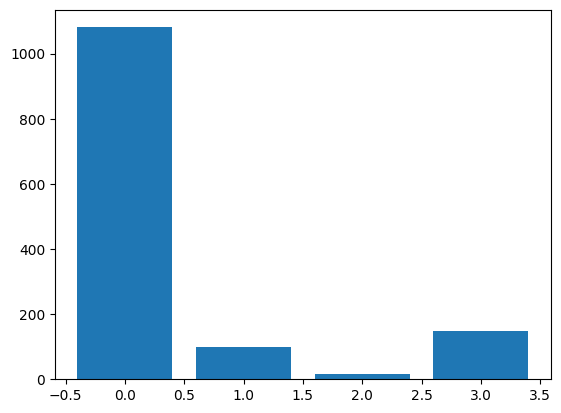

Class=0, n=1081 (25.000%)
Class=1, n=1081 (25.000%)
Class=3, n=1081 (25.000%)
Class=2, n=1081 (25.000%)


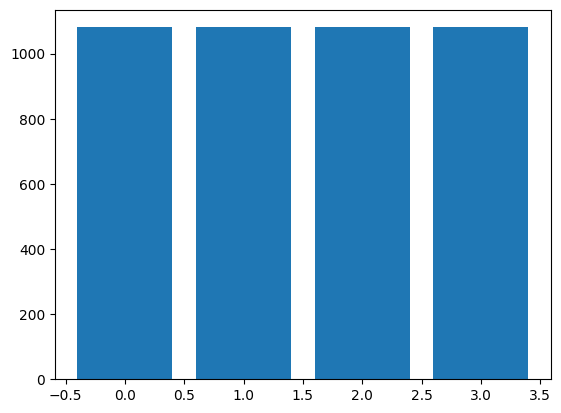

     age_at_diagnosis  chemotherapy  neoplasm_histologic_grade  \
321             68.41             0                        NaN   
813             41.29             1                        3.0   
637             60.58             1                        3.0   
263             36.25             0                        2.0   
548             49.35             1                        2.0   

     mutation_count  nottingham_prognostic_index  overall_survival_months  \
321             8.0                       1.0760               199.033333   
813            15.0                       6.1100               165.433333   
637             5.0                       5.0800                85.366667   
263             7.0                       3.0460               269.633333   
548             7.0                       3.0046               146.833333   

    3-gene_classifier_subtype  tumor_size   brca1   brca2  ...  srd5a1  \
321      ER+/HER2- Low Prolif        38.0 -0.0283 -0.2112  ... -1.

KeyError: "['cellularity', 'death_from_cancer', 'pam50_+_claudin-low_subtype', 'her2_status_measured_by_snp6'] not in index"

In [8]:
x_train_encoded,y_train_encoded,selected_features_indices = preprocess_data(x_train,y_train)
# select selected_features_indices from x_test
x_test = x_test.iloc[:, selected_features_indices]
print(x_test.head())

In [13]:
ordinal_features = ['3-gene_classifier_subtype']# should add the genetic mutation cols too
x_test[ordinal_features] = x_test[ordinal_features].apply(LabelEncoder().fit_transform)
# all nominal features and genetic mutations are omitted
x_test.to_csv("x_test.csv", index=False)

In [14]:
# encoding labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

x_test_encoded = impute_missing_values_KNN(x_test)

In [15]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    # 'min_child_weight': [1, 3, 5],
    # 'gamma': [0, 0.5, 1, 1.5],
    'eta': [0.01, 0.1, 0.2],
    # 'lambda': [0.01, 0.1, 1],
    # 'alpha': [0, 0.1, 0.5, 1],
    'max_depth': [3, 6, 9],
}

# Create a model
xgb_model = XGBClassifier(use_label_encoder=False, objective='multi:softprob')
# Create grid search object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1_macro',n_jobs=4)
# Fit the grid search object to the train data
grid_search.fit(x_train_encoded, y_train_encoded)

# Best hyperparameters
best_params = grid_search.best_params_
print("best params: ",best_params)

# Cross-validation f1-macro score
best_score = grid_search.best_score_
print("Cross-validation f1-macro score: ", best_score)

# Refit the model with best hyperparameters to the train data
best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(x_train_encoded, y_train_encoded)

# Predict labels of test data
y_test_pred = best_xgb_model.predict(x_test_encoded)

# Calculate performance metrics on Test Data
accuracy = accuracy_score(y_test_encoded, y_test_pred)
precision = precision_score(y_test_encoded, y_test_pred, average="macro")
recall = recall_score(y_test_encoded, y_test_pred, average="macro")
f1 = f1_score(y_test_encoded, y_test_pred, average="macro")

print("Evaluation on Test data: ")
print("accuracy =", accuracy)
print("precision =", precision)
print("recall =", recall)
print("f1-score =", f1)

# Save the best model
saveModel('best_xgb_model_main_7.pkl', best_xgb_model)

Cross-validation f1-macro score:  0.9756364845945524
Evaluation on Test data: 
accuracy = 0.7933333333333333
precision = 0.5559006211180124
recall = 0.4514603510895884
f1-score = 0.4672570097117794


In [ ]:
# plot learning curve for the best model
plot_learning_curves(best_xgb_model, x_train_encoded, y_train_encoded)

In [ ]:
selected_features_indices